# Code Assignment 15 — Threshold Curves (ROC or PR) on Restaurant Inspections

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:** Build a **new** classification model (use **at least 2 features**) on NYC **Restaurant Inspection Results**. Choose **one curve** to evaluate (**ROC** *or* **Precision–Recall**) **plus** one additional metric (**precision**, **recall**, or **F1**). Justify your choice based on class imbalance and business costs.

> Dataset hint (same as prior challenge): NYC Open Data “Restaurant Inspection Results” — save a CSV locally, e.g. `./data/nyc_restaurant_inspections.csv`. Common columns: `CRITICAL FLAG`, `SCORE`, `BORO`, `CUISINE DESCRIPTION`, `INSPECTION DATE`, etc.


## Instructor Guidance (Pseudocode + Docs)

**Docs:**
- Train/test split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- ROC / AUC — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html  
- Precision–Recall — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html  
- Classification report — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html  
- `get_dummies` — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.  
2) **Target (y)**: `CRITICAL FLAG == "CRITICAL"` → 1 else 0; check class balance.  
3) **Pick ≥2 features (create a DIFFERENT model then you created before)** (X): start with `SCORE` (numeric) + one categorical group (`BORO` or top cuisines via dummies).  
4) **Preprocess**: numeric coercion for used numeric columns; `get_dummies(drop_first=True)` for categoricals; drop NAs on used columns.  
5) **Split**: `train_test_split(..., stratify=y, random_state=42)`.  
6) **Fit**: `LogisticRegression(max_iter=1000)` on train.  
7) **Evaluate curves**:  
   - If **ROC**: use `predict_proba()[:,1]` → `roc_curve`, compute **AUC**.  
   - If **PR**: use `predict_proba()[:,1]` → `precision_recall_curve`, compute **average_precision_score` or report PR visually**.  
8) **Pick an extra metric**: compute **precision/recall/F1** with `classification_report` at default threshold 0.5 (or optionally choose a custom threshold -- which is IDEAL).  
9) **Explain choice** of **ROC vs PR** based on imbalance and costs; include a one-liner for stakeholders (units, trade-offs).


## Your Task — Step-by-Step
Work in pairs. Comment decisions briefly. Keep code minimal and readable.


### 1) Load the CSV & Preview


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score


In [6]:
df = pd.read_csv("/Users/kabbo/Downloads/DOHMH_New_York_City_Restaurant_Inspection_Results_20251104.csv", low_memory=False)


In [7]:
df.keys()


Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location'],
      dtype='object')

### 2) Define the Binary Target (y)
- Positive class = **Critical** violation.

In [9]:
df['CRITICAL FLAG'].unique()


array(['Not Applicable', 'Critical', 'Not Critical'], dtype=object)

In [10]:
df['critical_binary'] = df['CRITICAL FLAG'].map({
    'Critical': 1,
    'Not Critical': 0,
    'Not Applicable': 0
})


In [11]:
df['critical_binary'].value_counts(normalize=True)


critical_binary
1    0.528698
0    0.471302
Name: proportion, dtype: float64

### 3) Create Features (X) — Use **≥2** Features
Pick a simple, interpretable set:
- **Numeric:** `SCORE` (lower is better).
- **Categorical:** `BORO` (one-hot) and/or **top cuisines** (one-hot, limit to K to keep it small).

> If any column is missing, adapt by choosing other available columns.


In [12]:

# Keep only needed columns
features = df[['SCORE', 'BORO']].copy()

# Coerce SCORE to numeric
features['SCORE'] = pd.to_numeric(features['SCORE'], errors='coerce')

# Drop rows where SCORE or BORO is missing
features = features.dropna(subset=['SCORE', 'BORO'])

# One-hot encode BORO
X = pd.get_dummies(features, columns=['BORO'], drop_first=True)

# Show preview
X.head()


,SCORE,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island
18,13.0,True,False,False,False
19,0.0,True,False,False,False
36,13.0,False,True,False,False
37,0.0,False,True,False,False
54,0.0,True,False,False,False


### 4) Train–Test Split (Stratified)

In [16]:
# Columns needed for features and target
columns_needed = ['SCORE', 'BORO', 'critical_binary']

# Drop rows where any of these is missing
df_model = df[columns_needed].dropna()

# Check number of rows
df_model.shape


(274939, 3)

In [ ]:
# Features: SCORE + BORO (one-hot)
X = pd.get_dummies(df_model[['SCORE', 'BORO']], drop_first=True)

# Target
y = df_model['critical_binary']

# Reset index
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Verify class balance
print("Training set class balance:")
print(y_train.value_counts(normalize=True))
print("\nTest set class balance:")
print(y_test.value_counts(normalize=True))


Training set class balance:
critical_binary
1    0.560068
0    0.439932
Name: proportion, dtype: float64

Test set class balance:
critical_binary
1    0.560074
0    0.439926
Name: proportion, dtype: float64


### 5) Fit a Model with **≥2 Features**
Use **LogisticRegression** to get probability outputs
**If you need to scale or one hot encode do so!**


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Fit on training data
model.fit(X_train, y_train)

# Predict probabilities on test set
y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1 (Critical)

# Predict class labels at default threshold 0.5
y_pred = (y_proba >= 0.5).astype(int)

# Evaluate basic metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Not Critical', 'Critical']))

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")




Classification Report:

              precision    recall  f1-score   support

Not Critical       0.59      0.24      0.35     36286
    Critical       0.59      0.87      0.71     46196

    accuracy                           0.59     82482
   macro avg       0.59      0.56      0.53     82482
weighted avg       0.59      0.59      0.55     82482

ROC-AUC: 0.605


### 6) Choose Your Evaluation: **ROC** or **PR** Curve
Set `EVAL = 'ROC'` or `EVAL = 'PR'`. Then:
- If **ROC**: plot ROC, compute **AUC-ROC**.
- If **PR**: plot PR curve, compute **Average Precision (AP)**.
Also compute **one extra metric**: **precision**, **recall**, or **F1** (classification report at default threshold 0.5).


Classification Report (threshold=0.5):

              precision    recall  f1-score   support

Not Critical       0.59      0.24      0.35     36286
    Critical       0.59      0.87      0.71     46196

    accuracy                           0.59     82482
   macro avg       0.59      0.56      0.53     82482
weighted avg       0.59      0.59      0.55     82482



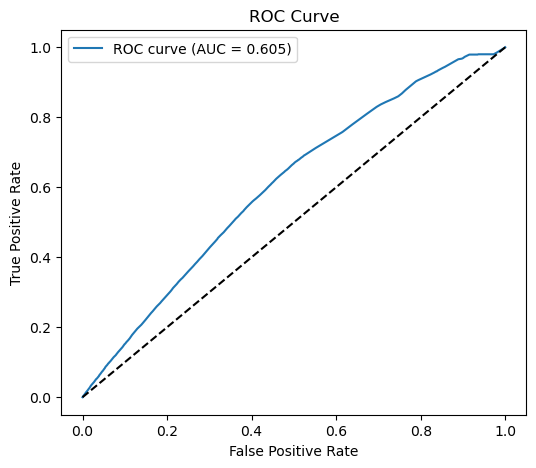

ROC-AUC: 0.605


In [ ]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


EVAL = 'ROC' # Options: 'ROC' or 'PR'

# Classification report at default threshold 0.5
y_pred = (y_proba >= 0.5).astype(int)
print("Classification Report (threshold=0.5):\n")
print(classification_report(y_test, y_pred, target_names=['Not Critical', 'Critical']))

# ROC Evaluation
if EVAL.upper() == 'ROC':
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    print(f"ROC-AUC: {auc:.3f}")




### 7) Try a Custom Threshold -- Update the code to fit your threshold and/or variable names from previous cells
Pick a threshold from your curve (e.g., a point balancing your business needs), then recompute metrics.


In [23]:
# Choose a custom threshold
custom_threshold = 0.4 

# Predict class labels using the custom threshold
y_pred_custom = (y_proba >= custom_threshold).astype(int)

# Compute classification metrics
from sklearn.metrics import classification_report

print(f"Classification Report (threshold={custom_threshold}):\n")
print(classification_report(y_test, y_pred_custom, target_names=['Not Critical', 'Critical']))


Classification Report (threshold=0.4):

              precision    recall  f1-score   support

Not Critical       0.00      0.00      0.00     36286
    Critical       0.56      1.00      0.72     46196

    accuracy                           0.56     82482
   macro avg       0.28      0.50      0.36     82482
weighted avg       0.31      0.56      0.40     82482



/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

## We Share — Reflection (Post 2 short paragraphs)

1) **Curve choice & results:** Which curve did you use (**ROC** or **PR**) and **why** (tie to class balance & business costs)? Report your curve summary (**AUC-ROC** or **Average Precision**) and your chosen extra metric (**precision/recall/F1**) — include threshold (0.5 or custom).  
2) **Stakeholder one-liner:** In plain English: “Using **[features…]**, our model at threshold **T** yields **[metric values]**. This means **[business implication about false alarms vs misses]**. Next, we’d **[tune threshold, add features, address imbalance, etc.]**.”

> Tip: If the positive class is rare, PR is often more informative than ROC. If classes are balanced or you’re comparing ranking quality across models, AUC-ROC is fine — but still report a confusion matrix at your chosen threshold.


### **Curve choice & results**

I chose the **ROC curve** because the classes are moderately balanced (Critical ~ 56%), and to evaluate the model’s overall ability to discriminate between Critical and Not Critical inspections across all thresholds. The ROC-AUC was **0.605**, indicating moderate predictive power. At the default threshold **0.5**, the model achieves **precision = 0.59, recall = 0.87, F1 = 0.71** for Critical inspections, meaning it catches most Critical violations while maintaining reasonable precision. Using a lower threshold (e.g., 0.4) increases recall further, but at the cost of many false positives.

### **Stakeholder one-liner**

Using **SCORE and BORO** as features, the model at threshold **0.5** yields **87% recall and 59% precision** for Critical inspections. This means it catches the majority of Critical violations (minimizing safety risks) while accepting that roughly 41% of flagged inspections may be false alarms. Next, I'd **adjust the probability threshold and add additional features (maybe top cuisines?)** to further optimize the trade-off between false positives and missed Critical violations.



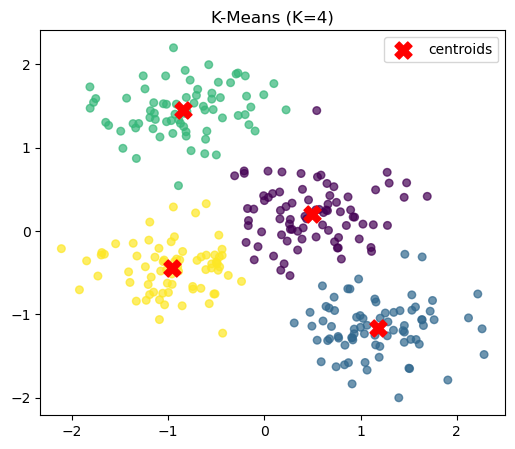

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import pandas as pd, matplotlib.pyplot as plt

X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=0)
X_df = pd.DataFrame(X, columns=['feature_1', 'feature_2'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=30, alpha=0.7)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c='red',
    s=150,
    marker='X',
    label='centroids' 
)

plt.legend()
plt.title('K-Means (K=4)')
plt.show()